In [1]:
import numpy as np
import ase.io
import tqdm
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from torch import nn
from nice.rascal_coefficients import process_structures
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
import time

In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
LAMBDA_MAX = 4
HARTREE_TO_EV = 27.211386245988
METHANE_PATH = '../methane.extxyz'
clebsch = ClebschGordan(LAMBDA_MAX)
HYPERS = {
    'interaction_cutoff': 3.5,
    'max_radial': 4,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_slice = "0:20000"
test_slice = '20000:25000'
GRID =   [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000,
          5000, 7500, 10000, 15000, 20000] #for learning curve
n_for_fit = 20000

train_structures = process_structures(ase.io.read(METHANE_PATH, index=train_slice))
test_structures = process_structures(ase.io.read(METHANE_PATH, index=test_slice))
all_species = get_all_species(train_structures + test_structures)
for struc in train_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])
for struc in test_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])
    

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean

In [5]:
def split(coefficients):
    lambd_max = max(coefficients.keys())
    even, odd = {}, {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[lambd]
        else:
            odd[str(lambd)] = coefficients[lambd]
    return even, odd

train_coefs = get_coefs(train_structures, HYPERS, all_species)
test_coefs = get_coefs(test_structures, HYPERS, all_species)

L2_mean = get_L2_mean(train_coefs)
print('l2: ', float(np.sqrt(L2_mean)))
for key in train_coefs.keys():
    train_coefs[key] /= np.sqrt(L2_mean)
    test_coefs[key] /= np.sqrt(L2_mean)
    
train_even, train_odd = split(train_coefs)
test_even, test_odd = split(test_coefs)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

l2:  0.0001892813597805798
0 torch.Size([20000, 8, 1])
2 torch.Size([20000, 8, 5])
4 torch.Size([20000, 8, 9])
0 torch.Size([5000, 8, 1])
2 torch.Size([5000, 8, 5])
4 torch.Size([5000, 8, 9])


In [ ]:
blocks = [[BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 500), 
                           None,
                           Compressor(50)), 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 1500), 
                           None,
                           Compressor(50))],
        [BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 500), 
                           None,
                           Compressor(50)), 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 1500), 
                           None,
                           Compressor(50))],
        [None, 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 1500), 
                           None,
                           Compressor(50))]]
nice = NICE(blocks, Compressor())
np.random.seed(0) 

even_for_fit, odd_for_fit = {}, {}
for key in train_even.keys():
    even_for_fit[key] = train_even[key][:n_for_fit]
for key in train_odd.keys():
    odd_for_fit[key] = train_odd[key][:n_for_fit]
begin = time.time()
nice.fit(even_for_fit, odd_for_fit)
print("time for fitting: ", time.time() - begin)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pozdn/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-db33c3916552>", line 26, in <module>
    nice.fit(even_for_fit, odd_for_fit)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 351, in fit
    even_old, odd_old)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 275, in fit
    self.compressor.fit(res_even, res_odd)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 53, in fit
    self.odd_linear = self.get_linear(odd)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 42, in get_linear
    svd.fit(now)
  File "/home/pozdn/.local/lib/python3.6/site-packages/sklearn/decomposition/_truncated_svd.py", line 146, in fit
    self.fit_transform(

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pozdn/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-db33c3916552>", line 26, in <module>
    nice.fit(even_for_fit, odd_for_fit)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 351, in fit
    even_old, odd_old)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 275, in fit
    self.compressor.fit(res_even, res_odd)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 53, in fit
    self.odd_linear = self.get_linear(odd)
  File "/home/pozdn/.local/lib/python3.6/site-packages/pytorch_prototype/nice_blocks.py", line 42, in get_linear
    svd.fit(now)
  File "/home/pozdn/.local/lib/python3.6/site-packages/sklearn/decomposition/_truncated_svd.py", line 146, in fit
    self.fit_transform(

In [5]:
def convert(features):
    result = {}
    for key in features.keys():
        result[key] = features[key].data.cpu().numpy()
    return result

begin = time.time()
train_features, _ = nice(train_even, train_odd)
print("time for train predictions: ", time.time() - begin)
train_features = convert(train_features)

begin = time.time()
test_features, _ = nice(test_even, test_odd)
print("time for test predictions: ", time.time() - begin)
test_features = convert(test_features)

time for train predictions:  58.57169771194458
time for test predictions:  10.421446800231934


In [6]:
print(train_features.keys())
print(test_features.keys())

dict_keys(['1', '2', '3', '4'])
dict_keys(['1', '2', '3', '4'])


(20000, 8)
(20000, 58)
(20000, 108)
(20000, 158)


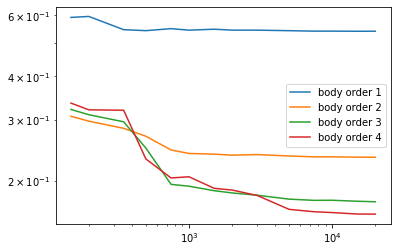

In [7]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lc(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

for index in range(1, 5):
    train = [train_features[str(i)] for i in range(1, index + 1)]
    test = [test_features[str(i)] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lc = get_lc(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lc, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
print(lc)

[0.33484792885824965, 0.32021603792728814, 0.3193314999376607, 0.23102006211628132, 0.20363611864312192, 0.2052559267892496, 0.19006141048254457, 0.18791569074824177, 0.18123623096335645, 0.16528789328840998, 0.1626567003993902, 0.16181100694865272, 0.1602126225993098, 0.16013737576165832]


(20000, 158)
(5000, 158)


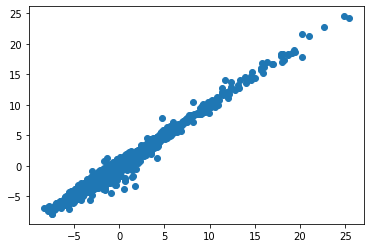

(158,)


In [9]:
print(train.shape)
rgr = BayesianRidge(fit_intercept = False)
rgr.fit(train, train_energies)
predictions = rgr.predict(test)
print(test.shape)
plt.plot(test_energies, predictions, 'o')
plt.show()
best_weight = rgr.coef_
print(best_weight.shape)

In [10]:
for key in train_features.keys():
    print(key, train_features[key].shape, np.mean(np.sum(train_features[key] * train_features[key], axis = 1)))

1 (20000, 8) 0.5442385
2 (20000, 50) 0.3070447
3 (20000, 50) 0.1843175
4 (20000, 50) 0.12333546
